In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax

In [11]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# # 1次元へ整形
# x_train, x_test = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [12]:
network = DeepConvNet()

# パラメータの保存
network.load_params("deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


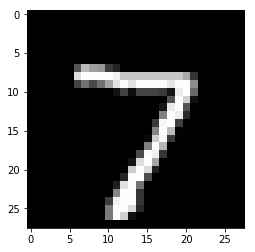

(28, 28)


In [13]:
x = x_test[0].copy()
plt.imshow(x, 'gray')
plt.show()
print(x.shape)

In [14]:
x = x.reshape(-1, 1, 28, 28)
pred = network.predict(x)
pred_probability = softmax(pred)
pred_probability

array([[4.09270345e-11, 4.14774472e-09, 6.66339952e-10, 2.53388230e-09,
        1.00733911e-09, 7.27067004e-11, 3.13935327e-12, 9.99999990e-01,
        2.84502728e-10, 1.17001944e-09]])

In [15]:
pred_label = np.argmax(pred, axis=1)
pred_label

array([7])

In [40]:
def generate_adv_jsma_2(x, target, network):
    adv = x.copy().reshape(1, 1, 28, 28)

    for _ in range(100):
        dj_list = []
        adv_c = adv.copy()
        for i in range(10):
            dj, gj = network.gradient_for_fgsm(adv, np.array([i]))
            dj = dj.reshape(-1)
            if i == target:
                dt = dj
                dj = np.zeros_like(dj)

            dj_list.append(dj)

        dj_list = np.array(dj_list)

        adv = adv.reshape(-1)

        for i, t in enumerate(dt):
            if t < 0:
                adv[i] = 0
            else:
                sum_dx = np.sum(dj_list, axis=0)
                if sum_dx[i] > 0:
                    adv[i] = 0
                else:
                    adv[i] = t * abs(sum_dx[i])
                    
        max_i = np.argmax(adv)
        
        adv2 = np.zeros_like(adv)
        
        adv2[max_i] = adv[max_i]

        adv = (adv_c + adv2.reshape(1, 1, 28, 28)).clip(min=0, max=1)
    
        
    plt.imshow(adv.reshape(28, 28))
    plt.show()
            
    return adv

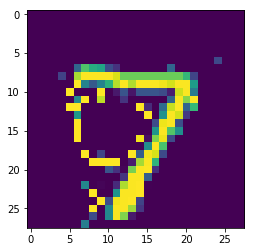

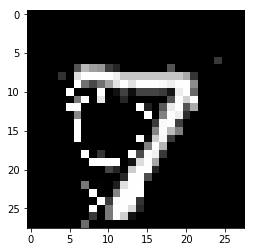

0.9573896277669909
[7]


In [42]:
adv_x = generate_adv_jsma_2(x, 1, network)
plt.imshow(adv_x.reshape(28, 28), 'gray')
plt.show()
pred = network.predict(adv_x)
pred_probability = softmax(pred)[0]
print(max(pred_probability))
pred_label = np.argmax(pred, axis=1)
print(pred_label)

In [ ]:
true_idxs = [[], [], [], [], [], [], [], [], [], []]
for i, t in enumerate(x_test):
    pre_l = np.argmax(network.predict(t.reshape(1, 1, 28, 28)))
    true_l = t_test[i]
    if pre_l == true_l:
        true_idxs[true_l].append(i)

In [ ]:
def compare_eps(x, target, network, loop, eps_list):
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = fig.add_subplot(5, 5, 1)
    ax.imshow(x, 'gray')
    pre = network.predict(x.reshape(1, 1, 28, 28))
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 4)
    ax.set_title(f"base, {pre_label} : {pre_score}")

    for i, eps in enumerate(eps_list):
        adv = generate_adv_jsma(x.reshape(1, 1, 28, 28), target, network, eps, loop)
        ax = fig.add_subplot(5, 5, i+2)
        ax.imshow(adv.reshape(28,28), 'gray')
        adv_pre = network.predict(adv)
        adv_label = np.argmax(adv_pre)
        adv_score = round(max(softmax(adv_pre[0])), 4)
        ax.set_title(f"eps[{eps}], {adv_label} : {adv_score}")

    plt.show()

In [ ]:
eps_list = [0, 0.4, 0.3, 0.2, 0.1, 0.07, 0.05, 0.01, 0.009, 0.008, 0.007, 0.005, 0.003, 0.001]
compare_eps(x.reshape(28, 28), 1, network, 100, eps_list)

In [ ]:
true_x_list_1 = []
for i in range(10):
    true_idx = true_idxs[i][0]
    true_x_list_1.append(x_test[true_idx])
    
true_x_list_1 = np.array(true_x_list_1)
true_x_list_1.shape

In [ ]:
for i, x in enumerate(true_x_list_1):
    x = x.reshape(1, 1, 28, 28)
    print(i)
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)
    ax = fig.add_subplot(1, 11, 1)
    ax.imshow(x.reshape(28,28), 'gray')
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 3)
    ax.set_title(f"base, {pre_label} : {pre_score}")
    
    for j in range(10):
        adv = generate_adv_jsma(x, j, network, 0.01, 100)
        ax = fig.add_subplot(1, 11, j+2)
        ax.imshow(adv.reshape(28,28), 'gray')
        pre = network.predict(adv)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 3)
        ax.set_title(f"{pre_label} : {pre_score}")

    plt.show()